In [21]:
!pip install -q torch_summary
!pip install -q torch_snippets
from torch_snippets import *
from torchsummary import summary
from torchvision import transforms
import cv2, numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'

!wget https://www.dropbox.com/s/rbajpdlh7efkdo1/male_female_face_images.zip
!unzip -q male_female_face_images.zip

--2022-06-02 04:51:31--  https://www.dropbox.com/s/rbajpdlh7efkdo1/male_female_face_images.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/rbajpdlh7efkdo1/male_female_face_images.zip [following]
--2022-06-02 04:51:31--  https://www.dropbox.com/s/raw/rbajpdlh7efkdo1/male_female_face_images.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc47b2b7731782586969dfbdf9cb.dl.dropboxusercontent.com/cd/0/inline/Bmakl80k-Qm-k93VN8No1TVPAarxxEdG7ZTW_2dZ4rDQ1Ord94gP8xWiK6fVGejbkmtiaMAwS2qKcv_Z_ThG936lORcSQqFiPhpeKDiy0Soi4mVaq6zNOTlrbvOx7H_05V7RsVoq-oIou53Fh_4BgvDOJ7fGc6hCHzayIfquQ0lGZw/file# [following]
--2022-06-02 04:51:32--  https://uc47b2b7731782586969dfbdf9cb.dl.dropboxusercontent.com/cd/0/inline/Bmakl80k-Qm-k93VN8No1T

# **Image Preprocessing (Cropping images to capture faces)**

In [22]:
!mkdir only_faces
import glob
from glob import glob

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

!mkdir cropped_faces
images = Glob('/content/females/*.jpg')+Glob('/content/males/*.jpg')
for i in range(len(images)):
    img = read(images[i],1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        img2 = img[y:(y+h),x:(x+w),:]
    cv2.imwrite('cropped_faces/'+str(i)+'.jpg',cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))

mkdir: cannot create directory ‘only_faces’: File exists


In [23]:
transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# **Torch DataSet**

In [24]:
class Faces(Dataset):
    def __init__(self, folder):
        super().__init__()
        self.folder = folder
        self.images = sorted(Glob(folder))
    def __len__(self):
        return len(self.images)
    def __getitem__(self, ix):
        image_path = self.images[ix]
        image = Image.open(image_path)
        image = transform(image)
        return image

ds = Faces(folder='cropped_faces/')
dataloader = DataLoader(ds, batch_size=64, shuffle=True)

# **Weight Initialization - Make them have a smaller spread**

In [25]:
def w_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# **Discriminator Model**

In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*2,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*4,64*8,4,2,1,bias=False),
            nn.BatchNorm2d(64*8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*8,1,4,1,0,bias=False),
            nn.Sigmoid()
        )
        self.apply(w_init)
    def forward(self, input): return self.model(input)

In [27]:
discriminator = Discriminator()
summary(discriminator,input_size=(3,64,64))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       3,072
|    └─LeakyReLU: 2-2                    --
|    └─Conv2d: 2-3                       131,072
|    └─BatchNorm2d: 2-4                  256
|    └─LeakyReLU: 2-5                    --
|    └─Conv2d: 2-6                       524,288
|    └─BatchNorm2d: 2-7                  512
|    └─LeakyReLU: 2-8                    --
|    └─Conv2d: 2-9                       2,097,152
|    └─BatchNorm2d: 2-10                 1,024
|    └─LeakyReLU: 2-11                   --
|    └─Conv2d: 2-12                      8,192
|    └─Sigmoid: 2-13                     --
Total params: 2,765,568
Trainable params: 2,765,568
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       3,072
|    └─LeakyReLU: 2-2                    --
|    └─Conv2d: 2-3                       131,072
|    └─BatchNorm2d: 2-4                  256
|    └─LeakyReLU: 2-5                    --
|    └─Conv2d: 2-6                       524,288
|    └─BatchNorm2d: 2-7                  512
|    └─LeakyReLU: 2-8                    --
|    └─Conv2d: 2-9                       2,097,152
|    └─BatchNorm2d: 2-10                 1,024
|    └─LeakyReLU: 2-11                   --
|    └─Conv2d: 2-12                      8,192
|    └─Sigmoid: 2-13                     --
Total params: 2,765,568
Trainable params: 2,765,568
Non-trainable params: 0

# **Generator Model**

In [28]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100,64*8,4,1,0,bias=False,),
            nn.BatchNorm2d(64*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64*8,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64*4,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64*2,64,4,2,1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64,3,4,2,1,bias=False),
            nn.Tanh()
        )
        self.apply(w_init)
    def forward(self,input): return self.model(input)

In [29]:
generator = Generator()
summary(generator,input_size=(3,64,64))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─ConvTranspose2d: 2-1              819,200
|    └─BatchNorm2d: 2-2                  1,024
|    └─ReLU: 2-3                         --
|    └─ConvTranspose2d: 2-4              2,097,152
|    └─BatchNorm2d: 2-5                  512
|    └─ReLU: 2-6                         --
|    └─ConvTranspose2d: 2-7              524,288
|    └─BatchNorm2d: 2-8                  256
|    └─ReLU: 2-9                         --
|    └─ConvTranspose2d: 2-10             131,072
|    └─BatchNorm2d: 2-11                 128
|    └─ReLU: 2-12                        --
|    └─ConvTranspose2d: 2-13             3,072
|    └─Tanh: 2-14                        --
Total params: 3,576,704
Trainable params: 3,576,704
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─ConvTranspose2d: 2-1              819,200
|    └─BatchNorm2d: 2-2                  1,024
|    └─ReLU: 2-3                         --
|    └─ConvTranspose2d: 2-4              2,097,152
|    └─BatchNorm2d: 2-5                  512
|    └─ReLU: 2-6                         --
|    └─ConvTranspose2d: 2-7              524,288
|    └─BatchNorm2d: 2-8                  256
|    └─ReLU: 2-9                         --
|    └─ConvTranspose2d: 2-10             131,072
|    └─BatchNorm2d: 2-11                 128
|    └─ReLU: 2-12                        --
|    └─ConvTranspose2d: 2-13             3,072
|    └─Tanh: 2-14                        --
Total params: 3,576,704
Trainable params: 3,576,704
Non-trainable params: 0

# **Loss for Discriminator and Generator**

In [30]:
def train_discriminator(real_data, fake_data):
    d_optimizer.zero_grad()
    pred_r = discriminator(real_data)
    error_r = loss(pred_r.squeeze(), torch.ones(len(real_data)).to(device))
    error_r.backward()
    pred_f = discriminator(fake_data)
    error_f = loss(pred_f.squeeze(), torch.zeros(len(fake_data)).to(device))
    error_f.backward()
    d_optimizer.step()
    return error_r + error_f

def train_generator(fake_data):
    g_optimizer.zero_grad()
    pred = discriminator(fake_data)
    error = loss(pred.squeeze(), torch.ones(len(real_data)).to(device))
    error.backward()
    g_optimizer.step()
    return error

# **Prepare requisites and Train the model**

In [31]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

loss = nn.BCELoss()

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

EPOCH: 1.000	d_loss: 0.670	g_loss: 8.050	(55.00s - 1320.08s remaining)
EPOCH: 2.000	d_loss: 0.612	g_loss: 5.718	(106.75s - 1227.67s remaining)
EPOCH: 3.000	d_loss: 0.533	g_loss: 4.811	(158.08s - 1159.23s remaining)
EPOCH: 4.000	d_loss: 0.520	g_loss: 4.053	(209.29s - 1098.77s remaining)
EPOCH: 5.000	d_loss: 0.568	g_loss: 3.681	(260.52s - 1042.08s remaining)
EPOCH: 6.000	d_loss: 0.597	g_loss: 3.539	(312.03s - 988.08s remaining)
EPOCH: 7.000	d_loss: 0.619	g_loss: 3.268	(363.44s - 934.56s remaining)
EPOCH: 8.000	d_loss: 0.632	g_loss: 3.150	(414.88s - 881.62s remaining)
EPOCH: 9.000	d_loss: 0.656	g_loss: 3.094	(467.17s - 830.52s remaining)
EPOCH: 10.000	d_loss: 0.596	g_loss: 3.053	(519.00s - 778.49s remaining)
EPOCH: 11.000	d_loss: 0.564	g_loss: 3.052	(571.20s - 726.98s remaining)
EPOCH: 12.000	d_loss: 0.636	g_loss: 3.067	(623.26s - 675.20s remaining)
EPOCH: 13.000	d_loss: 0.559	g_loss: 2.997	(674.71s - 622.81s remaining)
EPOCH: 14.000	d_loss: 0.550	g_loss: 3.065	(726.13s - 570.53s remainin

100%|██████████| 126/126 [00:00<00:00, 183.08it/s]


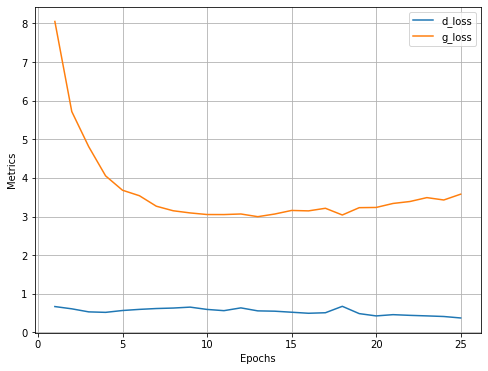

In [32]:
log = Report(25)
for epoch in range(25):
    N = len(dataloader)
    for i, images in enumerate(dataloader):
        real_data = images.to(device)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        fake_data = fake_data.detach()
        d_loss = train_discriminator(real_data, fake_data)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        g_loss = train_generator(fake_data)
        log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(), end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['d_loss','g_loss'])

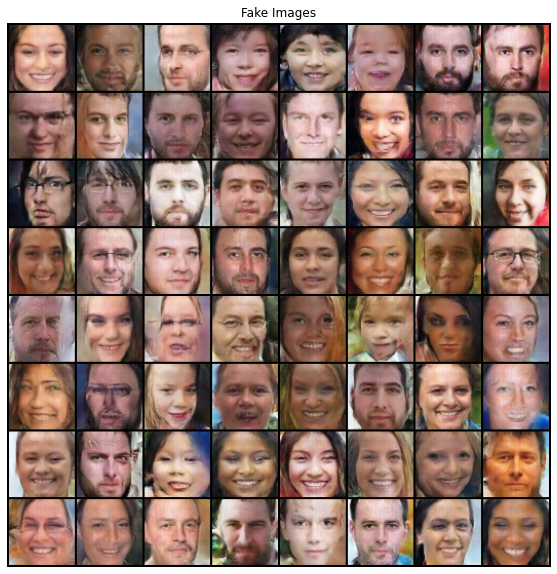

In [34]:
from torchvision.utils import make_grid
generator.eval()
z = torch.randn(64,100,1,1).to(device)
fake_images = generator(z).cpu().detach()
grid_images = make_grid(fake_images,nrow=8,ncol=8,normalize=True)
show(grid_images.cpu().detach().permute(1,2,0),sz=10,title="Fake Images")